In [1]:
import random
import matplotlib.pyplot as plt


In [177]:
class Node:
    Nodes = {}  # Dictionnaire pour stocker tous les nœuds
    p_values = {}
    loss_history = {}  # Historique des erreurs globales

    def __init__(self, node_id, p_one_value, buffer_size=20, learning_rate=0.001):
        """
        Initialise un nœud.
        
        :param node_id: Identifiant unique du nœud.
        :param p_one_value: Probabilité de succès d'envoi d'un message (entre 0 et 1).
        :param buffer_size: Taille maximale du buffer pour stocker les messages reçus.
        :param learning_rate: Taux d'apprentissage pour la descente de gradient.
        """
        self.node_id = node_id
        self.p_one_value = p_one_value
        self.buffer_size = buffer_size
        self.buffer = {}
        self.guess_buffer = {}
        self.connected_nodes = []  # Liste des nœuds connectés
        self.p_values = {}  # Dictionnaire pour stocker les estimations de p-value des autres nœuds
        self.learning_rate = learning_rate  # Taux d'apprentissage pour la descente de gradient
        self.loss_history = {}  # Historique des erreurs locales
        Node.Nodes[node_id] = self
        Node.p_values[node_id] = 1  # Initialiser la p-value à 0.5 (aucune information)
        self.sents_message=[]

    @staticmethod
    def reset():
            """
            Réinitialise les nœuds.
            """
            Node.Nodes = {}
            Node.p_values = {}

    def connect(self, other_node):
        """
        Connecte ce nœud à un autre nœud.
        
        :param other_node: Un autre objet Node auquel ce nœud se connecte.
        """
        if other_node not in self.connected_nodes:
            self.connected_nodes.append(other_node)
            self.p_values[other_node.node_id] = 0.5  # Initialiser la p-value à 0.5 (aucune information)

    def send_message_p_value(self,p_one_value):
        """
        Simule l'envoi d'un message avec une probabilité de succès donnée.
        
        :return: 1 si le message est envoyé avec succès, 0 sinon.
        """
        if random.random() < p_one_value:
            return 1  # Succès
        else:
            return 0  # Échec
        
    def send_message_p_value_buffer(self,p_one_value,buffer):

        if not buffer:
            bit = self.send_message_p_value(p_one_value)
            buffer.append(bit)
            return bit

        actual_pvalue_0= sum(buffer)/(len(buffer)+1)
        actual_pvalue_1= (sum(buffer)+1)/(len(buffer)+1)

        distance_0= abs(p_one_value-actual_pvalue_0)
        distance_1= abs(p_one_value-actual_pvalue_1)

        bit = 0
        if distance_0 < distance_1:
            bit= 0
        else:
            bit = 1
            self.sents_message.append(bit)
        return bit
    
    def send_message(self):

        # return self.send_message_p_value(self.p_one_value)
        return self.send_message_p_value_buffer(self.p_one_value,self.sents_message[-self.buffer_size:])
        
    def guess_node_bit(self,node_id):
        if node_id not in self.guess_buffer:
            self.guess_buffer[node_id] = self.buffer.get(node_id, [])
        

            
        p_value = self.p_values.get(node_id, 0.5)
        buffer = self.guess_buffer[node_id]
        print(f"Node {self.node_id} guess bit of node {node_id} with p_value {p_value} and buffer {buffer}")
        bit = self.guess_bit(p_value,buffer)
        self.guess_buffer[node_id].pop(0)
        self.guess_buffer[node_id].append(bit)
        return bit
        
    def guess_bit(self,p_one_value,buffer):
        """
        Devine le bit d'un nœud en fonction des p-values estimées des nœuds connectés.
        """
        if not buffer:
            return self.send_message_p_value(p_one_value)
        actual_pvalue_0= sum(buffer)/(len(buffer)+1)
        actual_pvalue_1= (sum(buffer)+1)/(len(buffer)+1)

        distance_0= abs(p_one_value-actual_pvalue_0)
        distance_1= abs(p_one_value-actual_pvalue_1)

        if distance_0 < distance_1:
            return 0
        else:
            return 1

    def receive_message(self, message, sender_id):
        """
        Reçoit un message et l'ajoute au buffer si celui-ci n'est pas plein.
        
        :param message: Le message reçu.
        :param sender_id: L'identifiant du nœud envoyeur.
        """

        messages = self.buffer.get(sender_id, [])
        if len(messages) >= self.buffer_size:
            messages.pop(0)

        messages.append(message)
        self.buffer[sender_id] = messages
        
    def compute_error(self, sender_id):
        """
        Calcule l'erreur entre la p-value estimée et la valeur observée.
        
        :param sender_id: L'identifiant du nœud envoyeur.
        :param observed_value: La valeur observée (0 ou 1).
        :return: L'erreur.
        """
        if sender_id not in self.buffer or len(self.buffer[sender_id]) == 0:
            return 0
        
        true_p = sum(self.buffer[sender_id]) / len(self.buffer[sender_id])

        predicted_p = self.p_values.get(sender_id, 0.5)

        error = true_p - predicted_p

        return error

    def gradient_descent_update(self, sender_id, error):
        """
        Met à jour la p-value estimée en utilisant la descente de gradient.
        
        :param sender_id: L'identifiant du nœud envoyeur.
        :param error: L'erreur calculée.
        """
        if sender_id in self.p_values:
            self.p_values[sender_id] += self.learning_rate * error
            # S'assurer que la p-value reste dans l'intervalle [0, 1]
            self.p_values[sender_id] = max(0, min(1, self.p_values[sender_id]))

    def guess_other_node(self):
        """
        Devine la valeur d'un autre nœud en fonction des p-values estimées des nœuds connectés.
        """
        guess={}
        for other_node in self.connected_nodes:
            guess[other_node.node_id]= self.guess_bit(other_node.p_one_value,self.buffer.get(other_node.node_id, []))
        return guess
    
    @staticmethod
    def connect_nodes(list_nodes):
        """
        Connecte les nœuds entre eux.
        """
        for node1, node2 in list_nodes:
            Node.Nodes[node1].connect(Node.Nodes[node2])
            Node.Nodes[node2].connect(Node.Nodes[node1])

    @staticmethod
    def turn():
        """
        Traite un tour complet pour tous les nœuds.
        """
    

        for node in Node.Nodes.values():
            node.process_turn()

    @staticmethod
    def vote(node_id):
        """
        Tout les nodes connecté à un node guess le bit de ce node et la majorité l'emporte
        """
        node = Node.Nodes[node_id]
        votes = []
        for n in  node.connected_nodes :
            bit = n.guess_node_bit(node_id)
            votes.append(bit)

        return max(set(votes), key=votes.count)

    def process_turn(self):
        """
        Traite un tour complet pour ce nœud :
        1. Envoie un message à tous les nœuds connectés.
        2. Reçoit les messages des nœuds connectés.
        3. Estime les p-values et met à jour avec la descente de gradient.
        4. Calcule et affiche la loss.
        """
        # Envoyer un message à tous les nœuds connectés
        send_result = self.send_message()
        
        # print(f"Nœud {self.node_id} a envoyé un message -> Résultat: {send_result}")

        # Recevoir les messages des nœuds connectés
        for other_node in self.connected_nodes:
            other_node.receive_message(send_result, self.node_id)

        # Estimer les p-values et mettre à jour avec la descente de gradient
        self.learn()

    def learn(self):
        
        total_loss = 0
        for other_node in self.connected_nodes:
            error = self.compute_error(other_node.node_id)
            self.gradient_descent_update(other_node.node_id, error)
            total_loss += error ** 2  # Loss = erreur au carré (MSE)
            if other_node.node_id not in self.loss_history:
                self.loss_history[other_node.node_id] = []
            self.loss_history[other_node.node_id].append(error ** 2)
            
                

        
    @staticmethod
    def get_node(node_id):
        return Node.Nodes[node_id]

 
    @staticmethod
    def plot_loss_historys():
        """
        Affiche l'historique des erreurs globales avec matplotlib.
        """
        for node_id, node in Node.Nodes.items():
            turn_loss = []
            p_value = []
            for other_node in node.connected_nodes:
                turn_loss.append(other_node.loss_history[node_id])
                p_value.append(other_node.p_values[node_id])

            # somme des erreurs de chaque tour
            total_loss = [sum(x) for x in zip(*turn_loss)]
            # moyenne des p-values de chaque tour
            avg_p_value = sum(p_value) / len(p_value)
            Node.loss_history[node_id] = total_loss
            Node.p_values[node_id] = avg_p_value
            # print(f"Loss moyenne - Nœud {node_id}: {total_loss[-1]}")
            # print(f"P-value moyenne - Nœud {node_id}: {avg_p_value}")


        plt.figure(figsize=(10, 6))
        for node_id, loss_history in Node.loss_history.items():
            plt.plot(loss_history, label=f"Loss moyenne - Nœud {node_id}")
        plt.xlabel("Tours")
        plt.ylabel("Loss")
        plt.title("Évolution de la loss moyenne globale")
        plt.legend()
        plt.grid(True)
        plt.show()


    def plot_loss_history_all(self):
        """
        Affiche l'historique des erreurs locales avec matplotlib.
        """
        plt.figure(figsize=(10, 6))
        for node_id, loss_history in self.loss_history.items():
            plt.plot(loss_history, label=f"Loss moyenne - Nœud {node_id}")
        plt.xlabel("Tours")
        plt.ylabel("Loss")
        plt.title(f"Évolution de la loss moyenne - Nœuds")
        plt.legend()
        plt.grid(True)
        plt.show()



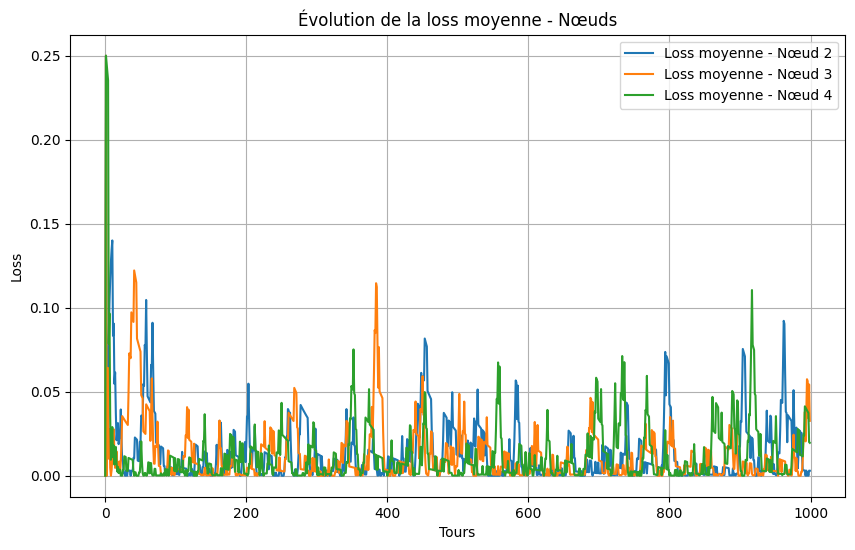

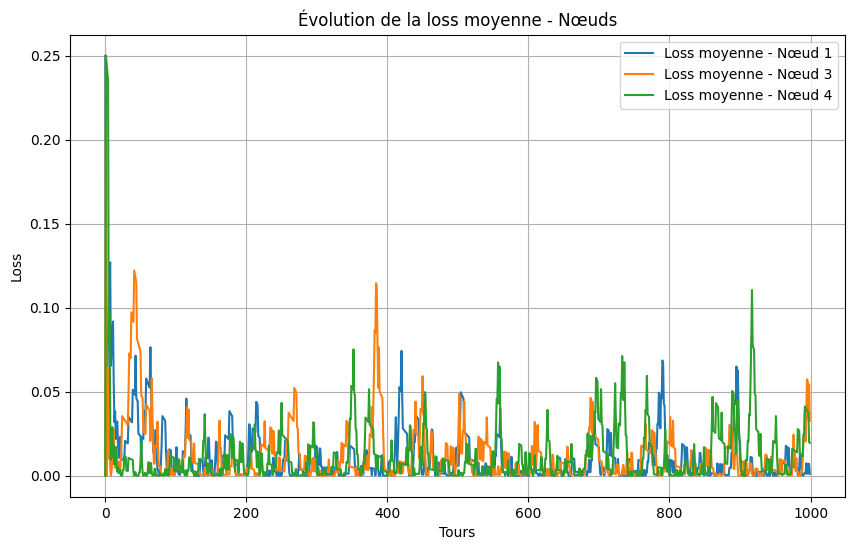

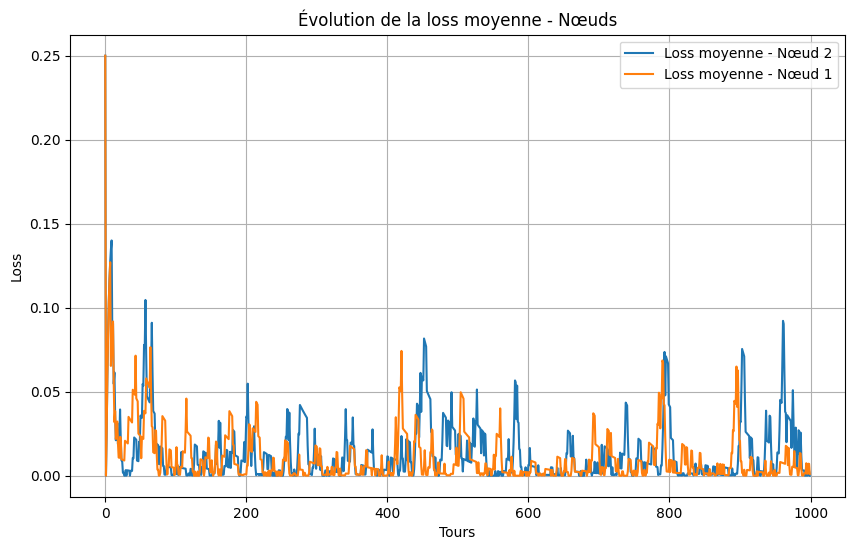

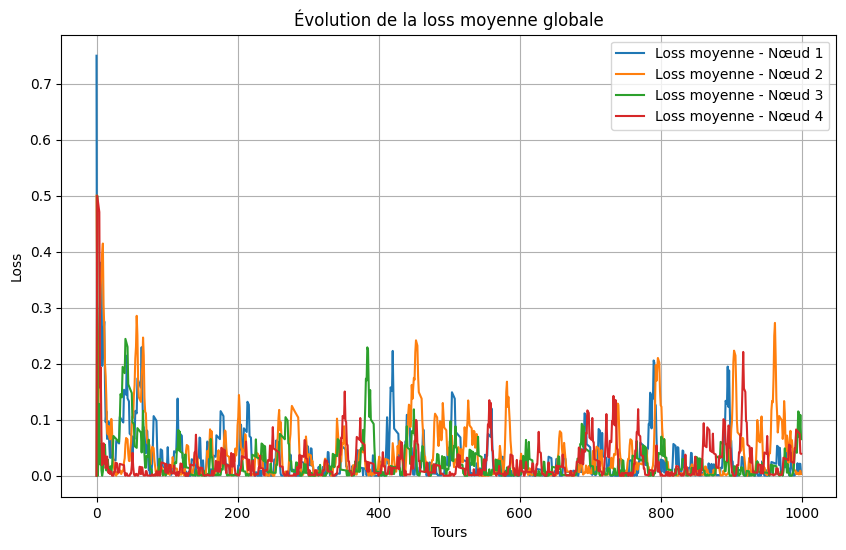


--- Comparaison des p-values ---
Nœud 1 - Estimé: 0.3326, Vrai: 0.3333, Erreur: 0.0007
Nœud 2 - Estimé: 0.4962, Vrai: 0.5000, Erreur: 0.0038
Nœud 3 - Estimé: 0.6789, Vrai: 0.6667, Erreur: 0.0123
Nœud 4 - Estimé: 0.6615, Vrai: 0.6000, Erreur: 0.0615

Nœud 1 - Comparaison des p-values:
  Nœud 2 - Estimé: 0.4961, Vrai: 0.5000, Erreur: 0.0039
  Nœud 3 - Estimé: 0.6789, Vrai: 0.6667, Erreur: 0.0123
  Nœud 4 - Estimé: 0.6615, Vrai: 0.6000, Erreur: 0.0615

Nœud 2 - Comparaison des p-values:
  Nœud 1 - Estimé: 0.3326, Vrai: 0.3333, Erreur: 0.0007
  Nœud 3 - Estimé: 0.6789, Vrai: 0.6667, Erreur: 0.0123
  Nœud 4 - Estimé: 0.6615, Vrai: 0.6000, Erreur: 0.0615

Nœud 3 - Comparaison des p-values:
  Nœud 2 - Estimé: 0.4962, Vrai: 0.5000, Erreur: 0.0038
  Nœud 1 - Estimé: 0.3326, Vrai: 0.3333, Erreur: 0.0007

Nœud 4 - Comparaison des p-values:
  Nœud 1 - Estimé: 0.3326, Vrai: 0.3333, Erreur: 0.0007
  Nœud 2 - Estimé: 0.4962, Vrai: 0.5000, Erreur: 0.0038


In [181]:
# Créer des nœuds
node1 = Node(node_id=1, p_one_value=1/3, learning_rate=0.01)
node2 = Node(node_id=2, p_one_value=1/2, learning_rate=0.01)
node3 = Node(node_id=3, p_one_value=2/3, learning_rate=0.01)
node4 = Node(node_id=4, p_one_value=3/5, learning_rate=0.01)


# Connecter les nœuds
Node.connect_nodes([(1, 2), (2, 3), (3, 1), (1, 4), (4, 2)])


num_turns = 1000
for turn in range(num_turns):
    # print(f"\n--- Tour {turn + 1} ---")
    Node.turn()

    
# Afficher l'historique des erreurs pour chaque nœud
node1.plot_loss_history_all()
node2.plot_loss_history_all()
node3.plot_loss_history_all()

# Afficher l'historique des erreurs globales
Node.plot_loss_historys()
# Comparer les p-values estimées avec les vraies p-values
print("\n--- Comparaison des p-values ---")


# global loss
for node in [node1, node2, node3, node4]:
    true_p = node.p_one_value
    estimated_p = Node.p_values[node.node_id]
    print(f"Nœud {node.node_id} - Estimé: {estimated_p:.4f}, Vrai: {true_p:.4f}, Erreur: {abs(estimated_p - true_p):.4f}")


for node in [node1, node2, node3, node4]:
    print(f"\nNœud {node.node_id} - Comparaison des p-values:")
    for other_node_id, estimated_p in node.p_values.items():
        true_p = Node.get_node(other_node_id).p_one_value
        print(f"  Nœud {other_node_id} - Estimé: {estimated_p:.4f}, Vrai: {true_p:.4f}, Erreur: {abs(estimated_p - true_p):.4f}")


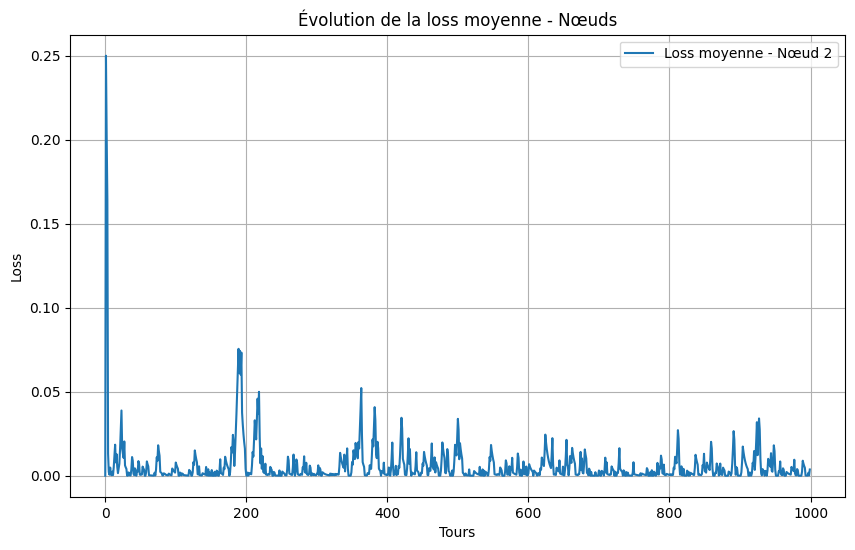


--- Comparaison des p-values ---

Nœud 1 - Comparaison des p-values:
 Nœud 2 - Estimé: 0.5452, Vrai: 0.5000, Erreur: 0.0452


In [160]:
# Créer des nœuds
alice = Node(node_id=1, p_one_value=1/3, learning_rate=0.1)
bob = Node(node_id=2, p_one_value=1/2, learning_rate=0.1)

# Connecter les nœuds
Node.connect_nodes([(1, 2)])


num_turns = 1000
for turn in range(num_turns):
    # print(f"\n--- Tour {turn + 1} ---")
    Node.turn()

    
# Afficher l'historique des erreurs pour chaque nœud
alice.plot_loss_history_all()

# Comparer les p-values estimées avec les vraies p-values
print("\n--- Comparaison des p-values ---")



for node in [alice]:
    print(f"\nNœud {node.node_id} - Comparaison des p-values:")
    for other_node_id, estimated_p in node.p_values.items():
        true_p = Node.get_node(other_node_id).p_one_value
        print(f" Nœud {other_node_id} - Estimé: {estimated_p:.4f}, Vrai: {true_p:.4f}, Erreur: {abs(estimated_p - true_p):.4f}")
    